# Tensorflow Model For Image Classification

##### Import pandas library

<p> Pandas library are used to read data from CSV, as the given data are in CSV format. </p>

In [77]:
import pandas as pd

##### Use pandas to load and save csv data to variable

In [78]:
source_data = pd.read_csv('data/train.csv')
print(source_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


<p> Analysis which is pulled from given result above </p>
</br>
<ol>
    <li> Rows in given data are a representative of an image </li>
    <li> Each column contains value range from 0 - 255 </li>
    <li> White is '0', Black is '255' </li>
    <li> For testing the model, I will give a 0.75 train and 0.25 validation training</li>
</ol>


##### Import train_test_split function from sklearn libraries

<p> Use train_test_split function to split the datasets into 75% for training and 25% for validation </p>

<p> After spliting, <i>labels</i> column will be deleted </p>

In [79]:
from sklearn.model_selection import train_test_split

train_data, validation_data = train_test_split(source_data, test_size=0.25)

print(train_data.info())
print("-----")
print(validation_data.info())

train_data_label = train_data.pop('label')
validation_data_label = validation_data.pop('label')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31500 entries, 34694 to 32294
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 188.9 MB
None
-----
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10500 entries, 9865 to 6721
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 63.0 MB
None


<p> Generate tensorflow data object from the datasets variables for both train and validation data using the 'from_tensor_slices' imported from the 'tf.data.Dataset' </p>

In [80]:
import tensorflow

train_data_tensorflow = tensorflow.data.Dataset.from_tensor_slices((train_data.values,train_data_label.values))
validation_data_tensorflow = tensorflow.data.Dataset.from_tensor_slices((validation_data.values,validation_data_label.values))

print(train_data_tensorflow)
print("=")
print(validation_data_tensorflow)

<TensorSliceDataset element_spec=(TensorSpec(shape=(784,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
=
<TensorSliceDataset element_spec=(TensorSpec(shape=(784,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


<p> Create a 2D picture with a 28 x 28 shape using matplotlib.pyplot </p>

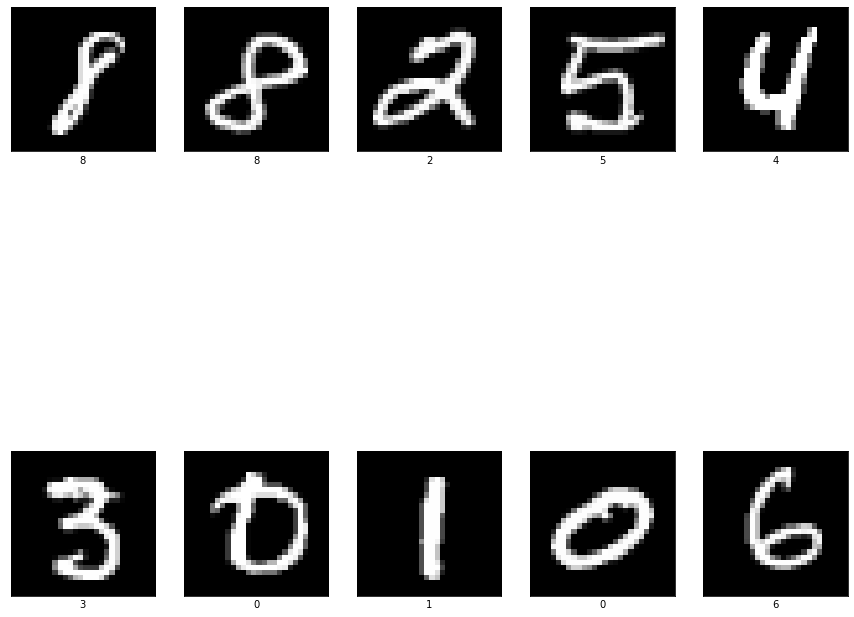

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
counter =0

for image_data, label_data in train_data_tensorflow.take(10):
    plt.subplot(2,5,counter+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(image_data.numpy().reshape((28,28)), cmap='gray')
    plt.xlabel(label_data.numpy())

    counter +=1

<p> The tensorflow data object needs to be reshape and scale for the model </p>

In [82]:
def image_reshape_and_scaler(image_data, label_data):
    image_data = tensorflow.reshape(image_data, [28,28,1])
    image_data = tensorflow.cast(image_data, tensorflow.float32) / 255.

    return image_data, label_data

train_data_tensorflow = train_data_tensorflow.map(image_reshape_and_scaler, num_parallel_calls=tensorflow.data.experimental.AUTOTUNE)

validation_data_tensorflow = validation_data_tensorflow.map(image_reshape_and_scaler, num_parallel_calls=tensorflow.data.experimental.AUTOTUNE)

print(train_data_tensorflow)
print(validation_data_tensorflow)

<ParallelMapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<ParallelMapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


<p> Create a function to: </p>

<ol>
    <li> Shuffle the data </li>
    <li> Create a logic treshold, to prevent from overloading the memory capacity (batch) </li>
    <li> prefetch the next data, to save time from loading and unloading the next data sequence </li>
</ol>

In [83]:
def shuffle_batch_prefetch(data_tensorflow):
    data_tensorflow = data_tensorflow.shuffle(100)
    data_tensorflow = data_tensorflow.batch(32)
    data_tensorflow = data_tensorflow.prefetch(tensorflow.data.experimental.AUTOTUNE)

    return data_tensorflow

train_data_tensorflow = shuffle_batch_prefetch(train_data_tensorflow)

validation_data_tensorflow = shuffle_batch_prefetch(validation_data_tensorflow)

print(train_data_tensorflow)
print(validation_data_tensorflow)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


<p> Create the neural network model and train the model </p>

In [84]:
model = tensorflow.keras.Sequential()

model.add(tensorflow.keras.layers.Conv2D(6, (5, 5), activation='relu', padding='same', input_shape=(28,28,1)))
model.add(tensorflow.keras.layers.MaxPooling2D(2,2))

model.add(tensorflow.keras.layers.Conv2D(16, (5, 5), activation='relu', padding='valid'))
model.add(tensorflow.keras.layers.MaxPooling2D(2,2))

model.add(tensorflow.keras.layers.Flatten())
model.add(tensorflow.keras.layers.Dense(120, activation='relu'))
model.add(tensorflow.keras.layers.Dense(84, activation='relu'))
model.add(tensorflow.keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 400)               0         
                                                                 
 dense_9 (Dense)             (None, 120)             

<p> Create the code statement to define the early stop and LRD (Learning Rate Decay) for the model </p>

In [85]:
callbacks_model = [
    tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbise=1),
    tensorflow.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

train_data_log = model.fit(train_data_tensorflow, validation_data=validation_data_tensorflow, epochs=30, callbacks=callbacks_model)


Epoch 1/30
985/985 [==============================] - 9s 9ms/step - loss: 0.2616 - accuracy: 0.9204 - val_loss: 0.0928 - val_accuracy: 0.9722 - lr: 0.0010
Epoch 2/30
985/985 [==============================] - 11s 11ms/step - loss: 0.0800 - accuracy: 0.9753 - val_loss: 0.0745 - val_accuracy: 0.9771 - lr: 0.0010
Epoch 3/30
985/985 [==============================] - 11s 11ms/step - loss: 0.0579 - accuracy: 0.9819 - val_loss: 0.0641 - val_accuracy: 0.9799 - lr: 0.0010
Epoch 4/30
985/985 [==============================] - 11s 11ms/step - loss: 0.0414 - accuracy: 0.9867 - val_loss: 0.0521 - val_accuracy: 0.9846 - lr: 0.0010
Epoch 5/30
985/985 [==============================] - 12s 12ms/step - loss: 0.0336 - accuracy: 0.9890 - val_loss: 0.0554 - val_accuracy: 0.9845 - lr: 0.0010
Epoch 6/30
985/985 [==============================] - 11s 11ms/step - loss: 0.0269 - accuracy: 0.9910 - val_loss: 0.0548 - val_accuracy: 0.9847 - lr: 0.0010
Epoch 7/30
985/985 [==============================] - 12s 12

<p> Create the plot graph and value of the training and validation accuracy </p>

Accuracy result of Training: 1.000000
Accuracy result of Validation: 0.987429


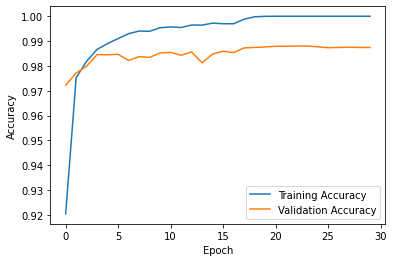

In [86]:
plt.plot(train_data_log.history['accuracy'], label='Training Accuracy')
plt.plot(train_data_log.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

Final_result_training_accuracy = train_data_log.history['accuracy'][-1]
Final_validation_training_accuracy = train_data_log.history['val_accuracy'][-1]

print('Accuracy result of Training: %4f' % Final_result_training_accuracy)
print('Accuracy result of Validation: %4f' % Final_validation_training_accuracy)

<p> Test the trained model with the test datasets </p>

In [92]:
import numpy

source_test_data = pd.read_csv('data/test.csv')
source_test_data_tersorflow = tensorflow.data.Dataset.from_tensor_slices(
    (
        [
            source_test_data.to_numpy().reshape(len(source_test_data),28,28,1)
        ]
    )
)
print(source_test_data_tersorflow)

prediction_data = model.predict(source_test_data_tersorflow)
prediction_data = numpy.argmax(prediction_data, axis=1)

<TensorSliceDataset element_spec=TensorSpec(shape=(28000, 28, 28, 1), dtype=tf.int64, name=None)>
1/1 [==============================] - 1s 1s/step


<p> Create a plot graph to heck if the prediction is accurate </p>

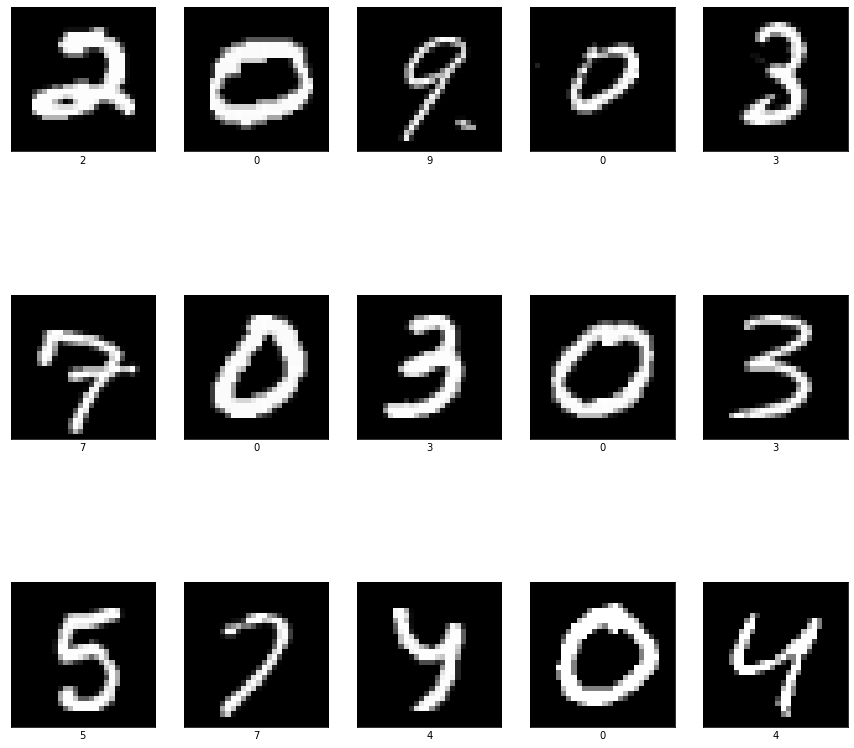

In [94]:
plt.figure(figsize=(15,15))

for count, current_row in source_test_data.head(15).iterrows():
    plt.subplot(3,5,count+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(current_row.values.reshape((28,28)), cmap='gray')
    plt.xlabel(prediction_data[count])

<p> Generate the result to a csv file </p>

In [97]:
predictions_result = pd.DataFrame(
    data={'Label': prediction_data},
    index=pd.RangeIndex(start=1, stop=28001)
)

predictions_result.index = predictions_result.index.rename('Image Identification')

predictions_result.to_csv('Result_of_Prediction.csv')